In [1]:
import pandas as pd
from plotnine import *
import numpy as np
from adjustText import adjust_text

# Combining endogenous DNA with sourcepredict

In [2]:
d = pd.read_csv("../../data/coproID_result.csv", index_col=0)

Endogenous DNA prediction

In [3]:
human_endo = d['normalized_bp_proportion_aligned_Homo_sapiens']/ (d['normalized_bp_proportion_aligned_Homo_sapiens'] + d['normalized_bp_proportion_aligned_Canis_familiaris']) > (2/3)

In [4]:
dog_endo = d['normalized_bp_proportion_aligned_Canis_familiaris']/ (d['normalized_bp_proportion_aligned_Homo_sapiens'] + d['normalized_bp_proportion_aligned_Canis_familiaris']) > (2/3)

In [5]:
d['endo_pred'] = ['Uncertain'] * d.shape[0]
d['endo_pred'] = np.where((human_endo == False) & (dog_endo == True), 'Dog', d['endo_pred'])
d['endo_pred'] = np.where((human_endo == True) & (dog_endo == False), 'Human', d['endo_pred'])

In [6]:
d['endo_pred']

AHP001_A0101_SG1_1_S0          Dog
AHP001_B0101_SG1_1_S0          Dog
AHP002_A0101_SG1_1_S0          Dog
AHP002_B0101_SG1_1_S0          Dog
AHP003_A0101_SG1_1_S0          Dog
AHP003_B0101_SG1_1_S0          Dog
AHP004_A0101_SG1_1_S0          Dog
AHP004_B0101_SG1_1_S0          Dog
BRF001_A0101_SG1_1_S0          Dog
CBA001_A0101_SG1_1_S0          Dog
CMN001_D0101_SG1_1_S0          Dog
DRL001_A0101_SG1_1_S0          Dog
ECO004_D0101_SG1_1_S0    Uncertain
LEI010_A0101_SG1_1_S0    Uncertain
MLP001_A0101_SG1_1_S0          Dog
TRO001_A0101_SG1_1_S0          Dog
YRK001_A0101_SG1_1_S0          Dog
ZSM002                         Dog
ZSM005                       Human
ZSM023                         Dog
ZSM025                       Human
ZSM027                   Uncertain
ZSM028                   Uncertain
ZSM029                         Dog
Name: endo_pred, dtype: object

Microbiome composition prediction with sourcepredict

In [7]:
d['microbiome_pred'] = ['Unknown'] * d.shape[0]
d['microbiome_pred'] = np.where(d['metagenomic_proportion_Homo_sapiens'] > 0.5, 'Human', d['microbiome_pred'])
d['microbiome_pred'] = np.where(d['metagenomic_proportion_Canis_familiaris'] > 0.5, 'Dog', d['microbiome_pred'])

In [8]:
d['microbiome_pred']

AHP001_A0101_SG1_1_S0    Unknown
AHP001_B0101_SG1_1_S0    Unknown
AHP002_A0101_SG1_1_S0    Unknown
AHP002_B0101_SG1_1_S0    Unknown
AHP003_A0101_SG1_1_S0    Unknown
AHP003_B0101_SG1_1_S0    Unknown
AHP004_A0101_SG1_1_S0    Unknown
AHP004_B0101_SG1_1_S0    Unknown
BRF001_A0101_SG1_1_S0    Unknown
CBA001_A0101_SG1_1_S0    Unknown
CMN001_D0101_SG1_1_S0    Unknown
DRL001_A0101_SG1_1_S0    Unknown
ECO004_D0101_SG1_1_S0    Unknown
LEI010_A0101_SG1_1_S0    Unknown
MLP001_A0101_SG1_1_S0    Unknown
TRO001_A0101_SG1_1_S0    Unknown
YRK001_A0101_SG1_1_S0        Dog
ZSM002                     Human
ZSM005                     Human
ZSM023                     Human
ZSM025                     Human
ZSM027                     Human
ZSM028                     Human
ZSM029                     Human
Name: microbiome_pred, dtype: object

In [9]:
new_index = []
for i in list(d.index.str.split("_")):
    if len(i) > 1:
        new_index.append("_".join(i[0:2]))
    else:
        new_index.append(i[0])
d.index = new_index

In [10]:
d.head()

,normalized_bp_proportion_aligned_Homo_sapiens,normalized_bp_proportion_aligned_Canis_familiaris,metagenomic_proportion_Homo_sapiens,metagenomic_proportion_Canis_familiaris,coproID_proba_Homo_sapiens,coproID_proba_Canis_familiaris,endo_pred,microbiome_pred
AHP001_A0101,0.001732,0.998268,0.017157,0.036073,0.000030,0.036010,Dog,Unknown
AHP001_B0101,0.001784,0.998216,0.029145,0.061278,0.000052,0.061168,Dog,Unknown
AHP002_A0101,0.003693,0.996307,0.022543,0.047396,0.000083,0.047221,Dog,Unknown
AHP002_B0101,0.000740,0.999260,0.022181,0.046637,0.000016,0.046602,Dog,Unknown
AHP003_A0101,0.003601,0.996399,0.019724,0.041471,0.000071,0.041322,Dog,Unknown


Looking at consensus between Endogenous DNA and microbiome composition prediction

In [11]:
d['consensus'] = np.where(d['endo_pred'] == d['microbiome_pred'], 1, 0)
d['consensus'] = np.where((d['endo_pred'] == 'Uncertain') & (d['microbiome_pred'] == 'Unknown'), 1, d['consensus'])
d['categorical_consensus'] = np.where(d['endo_pred'] == d['microbiome_pred'], 'consensus', 'no consensus')
d['categorical_consensus'] = np.where((d['endo_pred'] == 'Uncertain') & (d['microbiome_pred'] == 'Unknown'), 'consensus', d['categorical_consensus'])

## Which proportion of the samples are predicted identical by both Endogenous DNA and Sourcepredict ?

In [12]:
d[['endo_pred','microbiome_pred','consensus','categorical_consensus']].sort_index()

,endo_pred,microbiome_pred,consensus,categorical_consensus
AHP001_A0101,Dog,Unknown,0,no consensus
AHP001_B0101,Dog,Unknown,0,no consensus
AHP002_A0101,Dog,Unknown,0,no consensus
AHP002_B0101,Dog,Unknown,0,no consensus
AHP003_A0101,Dog,Unknown,0,no consensus
AHP003_B0101,Dog,Unknown,0,no consensus
AHP004_A0101,Dog,Unknown,0,no consensus
AHP004_B0101,Dog,Unknown,0,no consensus
BRF001_A0101,Dog,Unknown,0,no consensus
CBA001_A0101,Dog,Unknown,0,no consensus


In [13]:
d['consensus'].sum()/d['consensus'].count()*100

20.833333333333336

In [14]:
d['coproID_prediction'] = ['Unknown'] * d.shape[0]
d['coproID_prediction'] = np.where(d['coproID_proba_Canis_familiaris'] > 0.5, 'Dog', d['coproID_prediction'])
d['coproID_prediction'] = np.where(d['coproID_proba_Homo_sapiens'] > 0.5, 'Human', d['coproID_prediction'])

In [16]:
d[['coproID_proba_Canis_familiaris','coproID_proba_Homo_sapiens', 'coproID_prediction']]
d['grepel_name'] = np.where(d['coproID_prediction'] != 'Unknown', d.index, None)

In [17]:
species_text = pd.DataFrame()

In [51]:
species_text['x'] = [0.25, 0.75, 0.75, 0.25]
species_text['y'] = [0.25, 0.25, 0.75, 0.75]
species_text['text'] = ['Unknown', 'Dog', 'Unknown', 'Human']

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:706: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:707: PlotnineWarning: Filename: results/figure5A.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/layer.py:453: PlotnineWarning: geom_text : Removed 19 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/layer.py:453: PlotnineWarning: geom_text : Removed 19 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


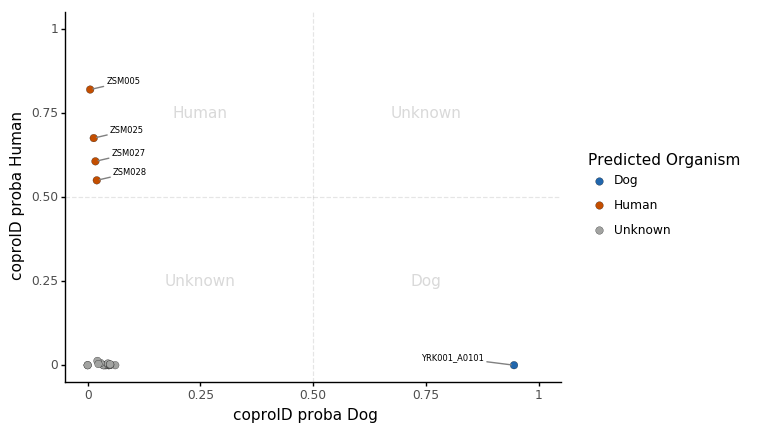

<ggplot: (8771626431629)>

In [52]:
p = ggplot(d, aes(x = 'coproID_proba_Canis_familiaris',y = 'coproID_proba_Homo_sapiens', label='grepel_name'))
p = p + geom_point(aes(fill="coproID_prediction"), color='black', stroke=0.1, size=3)
p = p + theme_classic() + labs(x='coproID proba Dog',y = 'coproID proba Human')
p = p + geom_text(size=6, adjust_text= {
    'expand_points': (2, 2),
    'expand_objects': (1.5, 2),
    'arrowprops': {
        'arrowstyle': '-',
        'color': 'grey'
    },
    'on_basemap':True
})
p = p + geom_text(data=species_text, mapping=aes(x='x',y='y', label='text'), alpha=0.3, color='grey')
p = p + geom_hline(yintercept=0.5, linetype='dashed', alpha=0.1) 
p = p + geom_vline(xintercept=0.5, linetype='dashed', alpha=0.1)
p = p + scale_fill_manual(name='Predicted Organism', values = {'Human':'#c44e00', 'Dog':'#2166ac', 'Unknown':'#a2a3a1'})
p = p + coord_cartesian(xlim=[0,1],ylim=[0,1])
p.save("results/figure5A.png", dpi=300)
p

In [53]:
species_text2 = species_text

In [58]:
species_text2['text'] = ['Unknown','Uncertain','Human','Uncertain']

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:706: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:707: PlotnineWarning: Filename: results/figure5B.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


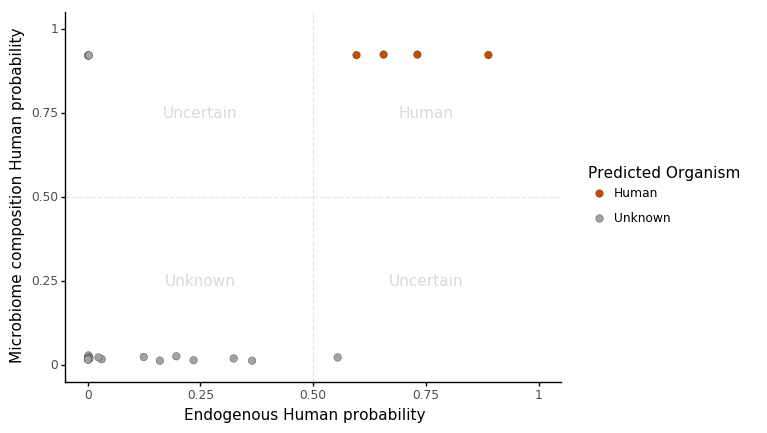

<ggplot: (-9223363265226099084)>

In [59]:
p2 = ggplot(data=d.query('coproID_prediction != "Dog"'))
p2 = p2 + geom_point(aes(x='normalized_bp_proportion_aligned_Homo_sapiens',y='metagenomic_proportion_Homo_sapiens', fill='coproID_prediction'), color='black', stroke=0.1, size=3)
p2 = p2 + geom_hline(yintercept=0.5, linetype='dashed', alpha=0.1) 
p2 = p2 + geom_vline(xintercept=0.5, linetype='dashed', alpha=0.1)
p2 = p2 + geom_text(data=species_text2, mapping=aes(x='x',y='y', label='text'), alpha=0.3, color='grey')
p2 = p2 + scale_fill_manual(name='Predicted Organism', values = {'Human':'#c44e00', 'Dog':'#2166ac', 'Unknown':'#a2a3a1'})
p2 = p2 + theme_classic() + labs(x='Endogenous Human probability',y = 'Microbiome composition Human probability')
p2 = p2 + coord_cartesian(xlim=[0,1],ylim=[0,1])
p2.save("results/figure5B.png", dpi=300)
p2

In [60]:
species_text3 = species_text2
species_text3['text'] = ['Unknown','Uncertain','Dog','Uncertain']

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:706: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:707: PlotnineWarning: Filename: results/figure5C.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


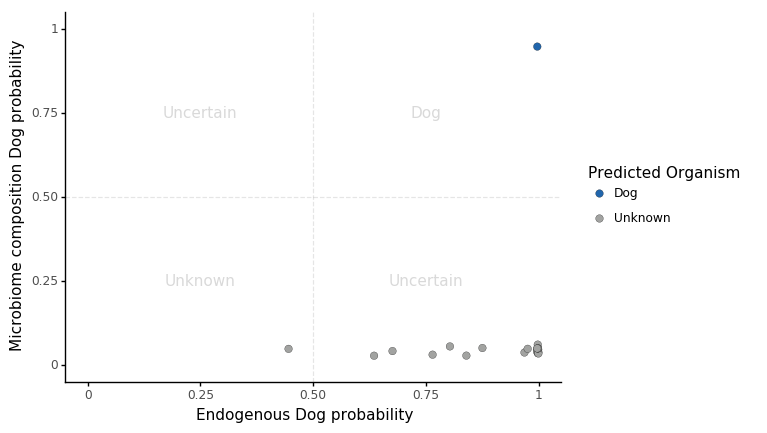

<ggplot: (8771628593002)>

In [61]:
p3 = ggplot(data=d.query('coproID_prediction != "Human"'))
p3 = p3 + geom_point(aes(x='normalized_bp_proportion_aligned_Canis_familiaris',y='metagenomic_proportion_Canis_familiaris', fill='coproID_prediction'), color='black', stroke=0.1, size=3)
p3 = p3 + geom_hline(yintercept=0.5, linetype='dashed', alpha=0.1) 
p3 = p3 + geom_vline(xintercept=0.5, linetype='dashed', alpha=0.1)
p3 = p3 + geom_text(data=species_text3, mapping=aes(x='x',y='y', label='text'), alpha=0.3, color='grey')
p3 = p3 + scale_fill_manual(name='Predicted Organism', values = {'Human':'#c44e00', 'Dog':'#2166ac', 'Unknown':'#a2a3a1'})
p3 = p3 + theme_classic() + labs(x='Endogenous Dog probability',y = 'Microbiome composition Dog probability')
p3 = p3 + coord_cartesian(xlim=[0,1],ylim=[0,1])
p3.save("results/figure5C.png", dpi=300)
p3